# Spam

This notebook is an example on how to use the VerticaPy Library. We will use the 'Spam' dataset to catch SMS spams. You can download the Jupyter Notebook of the study by clicking <a href="spam.ipynb">here</a>. Click <a href="../../data/spam.csv">here</a> to download the dataset

We have access to the following data:
<ul>
    <li><b>v1: </b> the SMS type (spam or ham)</li>
    <li><b>v2: </b> SMS content</li>
</ul>
	
We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this use-case. The purpose is to show you some of the library interesting functionalities.


## Initialization

Let's create the Virtual DataFrame of the dataset.

In [1]:
from verticapy import *
spam = vDataFrame("spam")
print(spam)

<object>  Name: spam, Number of rows: 5460, Number of columns: 2


## Data Exploration and Preparation

As the dataset study resides on Text Analytic. We need to create some features in order to compute some statistics. We can for example, compute the SMS length and use a label encoding on the 'type' to get a dummy (1 if the message is a SPAM, 0 otherwise). It is also judicious to convert the Message content to Lowercase (it will make the study easier).

In [2]:
spam.eval("length", "LENGTH(content)")
spam["content"].apply("LOWER({})")
spam["type"].decode({'spam': 1}, 0)

<object>  Name: spam, Number of rows: 5460, Number of columns: 3

Let's compute some statistics using the Length of the message.

In [3]:
spam['type'].describe(method = 'cat_stats', 
                      numcol = 'length')

<object>

We can notice that the SPAM are much longer than regular message ! Let's use the CountVectorizer to create a Dictionary and identify keywords. But let's first create a view with only the Spams.

In [4]:
drop_view("spams")
spam.to_db("spams", db_filter = ["type = 1"])

from verticapy.learn.preprocessing import CountVectorizer
from verticapy.utilities import drop_text_index
drop_text_index("spams_voc")
dict_spams = CountVectorizer("spams_voc")
dict_spams.fit("spams", ["content"])
dict_spams = dict_spams.to_vdf()
print(dict_spams)

The view spams was successfully dropped.
The text index spams_voc was successfully dropped.


<object>  Name: spams_voc, Number of rows: 2958, Number of columns: 4


Let's add the most occurent words in our vDataFrame and compute the correlation vector.

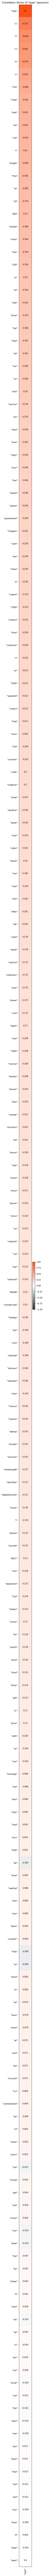

In [5]:
%matplotlib inline
for elem in dict_spams.head(200).values["token"]:
    spam.regexp(name = elem,
                pattern = elem,
                method = "count",
                column = "content")
x = spam.corr(focus = "type")

Let's keep only the first one hundred most correlated features and let's merge the numbers together.

In [6]:
spam.drop(columns = x.values["index"][101:])
for elem in x.values["index"][1:101]:
    if any(char.isdigit() for char in elem):
        spam[elem].drop()
spam.regexp(column = "content",
            pattern = "([0-9])+",
            method = "count",
            name = "nb_numbers")

<object>  Name: spam, Number of rows: 5460, Number of columns: 84

Let's also keep only the words having more than 2 characters.

In [7]:
for elem in spam.get_columns():
    if len(elem.replace('"', '')) <= 2:
        spam[elem].drop()

Let's compute again a correlation vector using the response column.

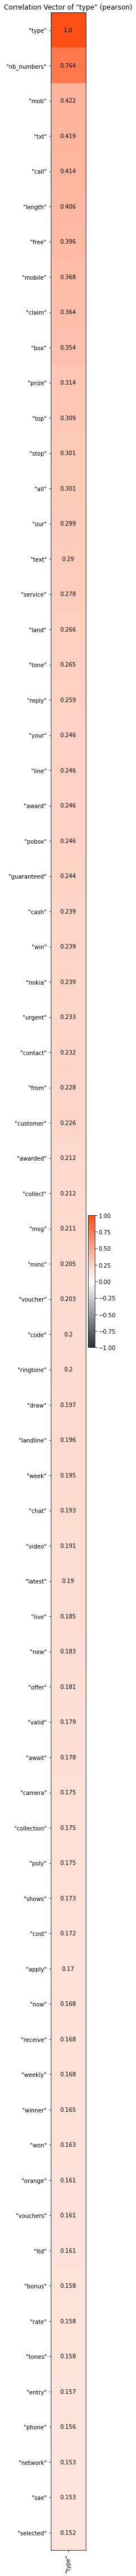

In [8]:
x = spam.corr(focus = "type")

We have enough correlated features with our response to create a fantastic model. We can export the final relation to the DataBase and start building our model.

In [9]:
drop_view("spam_clean")
spam.to_db("spam_clean")

The view spam_clean was successfully dropped.


<object>  Name: spam, Number of rows: 5460, Number of columns: 73

# Machine Learning

Naive Bayes is a Powerful and Performant Algorithm for Text Analytics Binary Classification use cases. That's why we will choose it to do the prediction. Before learning on all the data, let's first use a Cross Validation to test our model efficiency.

In [10]:
from verticapy.learn.naive_bayes import MultinomialNB
model = MultinomialNB("spam_nb")
model.drop()

from verticapy.learn.model_selection import cross_validate
cross_validate(model, 
               "spam_clean", 
               spam.get_columns(exclude_columns = ["type", "content"]), 
               "type", 
               cv = 5)

<object>

The model is excellent ! Let's learn on all the data.

In [11]:
model.fit("spam_clean", 
          spam.get_columns(exclude_columns = ["type", "content"]), 
          "type")
model.confusion_matrix()

<object>

We can use this model to identify future spams !

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.